# 1. Libraries 

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import tensorflow as tf

import seaborn as sns
sns.set_style('white')

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings(action='ignore')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# For Preprocessing 
import nltk
import re
# nltk.download('all') # all

import pycountry
from geotext import GeoText

In [3]:
# For checking GPU usage
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8072962299730191446
xla_global_id: -1
]
[]


In [4]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

In [5]:
# original train and test data -> original, test
original = pd.read_csv('train.csv')
test = pd.read_csv('submission.csv')

# preprocessed data -> data1(customer_country), data2(customer, business, proeuct, inquiry_type: 20)
train1 = pd.read_csv('train_processed_1.csv')
train2 = pd.read_csv('train_processed_2.csv')

# train data -> data
train = pd.concat([train1['country_preprocessing'], train2], axis=1).drop(['Unnamed: 0'], axis=1)
train.rename(columns = {"country_preprocessing": "customer_country"}, inplace=True)
original_cols = list(set(original.columns) - set(train.columns))
train = pd.concat([original[original_cols], train], axis=1)

train

,ver_cus,ver_win_ratio_per_bu,lead_desc_length,it_strategic_ver,idit_strategic_ver,expected_timeline,id_strategic_ver,lead_owner,ver_pro,is_converted,...,customer_job_full,customer_type_full,customer_full,product_category,product_subcategory,product_modelname,product_category_full,product_subcategory_full,product_modelname_full,product_full
0,1,0.026846,62,NaN,NaN,less than 3 months,NaN,0,0,True,...,purchasing,end customer,entry level purchasing end customer,multi split,NaN,NaN,multi split,NaN,NaN,multi split
1,1,0.026846,96,NaN,NaN,less than 3 months,NaN,1,0,True,...,media and communication,end customer,ceo founder media and communication end...,multi split,NaN,NaN,multi split,NaN,NaN,multi split
2,1,0.026846,56,NaN,NaN,less than 3 months,NaN,2,0,True,...,engineering,end customer,partner engineering end customer,single split,NaN,NaN,single split,NaN,NaN,single split
3,1,0.026846,44,NaN,NaN,less than 3 months,NaN,3,0,True,...,entrepreneurship,end customer,ceo founder entrepreneurship end customer,vrf,NaN,NaN,vrf,NaN,NaN,vrf
4,0,0.026846,97,NaN,NaN,less than 3 months,NaN,4,0,True,...,consulting,specifier influencer,partner consulting specifier influencer,multi split,NaN,NaN,multi split,NaN,NaN,multi split
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,0,0.028777,200,NaN,NaN,3 months ~ 6 months,NaN,694,0,False,...,engineering,end customer,entry level engineering end customer,vrf,NaN,NaN,vrf,NaN,NaN,vrf
59295,0,0.028777,70,NaN,NaN,9 months ~ 1 year,NaN,39,0,False,...,entrepreneurship,specifier influencer,trainee entrepreneurship specifier inf...,other,NaN,NaN,other,NaN,NaN,other
59296,0,0.028777,34,NaN,NaN,less than 3 months,NaN,125,0,False,...,engineering,specifier influencer,entry level engineering specifier infl...,single split,NaN,NaN,single split,NaN,NaN,single split
59297,0,0.028777,377,NaN,NaN,more than a year,NaN,134,0,False,...,entrepreneurship,NaN,other entrepreneurship,other,NaN,NaN,other,NaN,NaN,other


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ver_cus                   59299 non-null  int64  
 1   ver_win_ratio_per_bu      15304 non-null  float64
 2   lead_desc_length          59299 non-null  int64  
 3   it_strategic_ver          1121 non-null   float64
 4   idit_strategic_ver        4565 non-null   float64
 5   expected_timeline         28436 non-null  object 
 6   id_strategic_ver          3444 non-null   float64
 7   lead_owner                59299 non-null  int64  
 8   ver_pro                   59299 non-null  int64  
 9   is_converted              59299 non-null  bool   
 10  response_corporate        59299 non-null  object 
 11  customer_country.1        58317 non-null  object 
 12  customer_idx              59299 non-null  int64  
 13  enterprise                59299 non-null  object 
 14  ver_wi

# 2. Preprocessing

Train Dataset 
- train_y
- train_ml
- train_nlp

Test Dataset
- test_y
- test_ml
- test_nlp

In [58]:
# 직접 지정하거나 계속 사용할 변수에 대해 대문자로 작성하였습니다(코드규칙)
# 0) Divide dataset to train_ml and train_nlp
Y_COLS = ['is_converted']
NLP_COLS = ['inquiry_type', 
            'product_category', 'product_subcategory', 'product_modelname', 
            'product_category_full', 'product_subcategory_full', 'product_modelname_full', 'product_full', 
            'customer_position', 'customer_job', 'customer_type', 
            'customer_position_full', 'customer_job_full', 'customer_type_full', 'customer_full',           
            'business_area', 'business_subarea',
            'business_area_full', 'business_subarea_full', 'business_full']
ML_COLS = set(train.columns) - set(Y_COLS) - set(NLP_COLS)

train_y = train[Y_COLS].copy()
train_ml = train[ML_COLS].copy()
train_nlp = train[NLP_COLS].copy()

test_y = test[['is_converted', 'id']].copy()
test_ml = test[ML_COLS].copy()
test_nlp = test.drop(ML_COLS, axis=1).drop(['is_converted', 'id'], axis=1).copy()

print(train_y.shape)
print(train_ml.shape)
print(train_nlp.shape)

print(test_y.shape)
print(test_ml.shape)
print(test_nlp.shape)

(59299, 1)
(59299, 19)
(59299, 20)
(5271, 2)
(5271, 19)
(5271, 9)


##### Preprocessing Functions

In [ ]:
#expected_timeline preprocess
def preprocess_timeline(df, column_name):
    #- _ 기입자마다 다르게해놔서 변경
    df[column_name] = df[column_name].str.replace('_',' ')
    df[column_name] = df[column_name].str.replace('-','~')
    df[column_name] = df[column_name].str.replace('.','', regex=True)
    #6개월 이내 개수 : 108개 -> 3~6 개월로 원함으로 변경
    #5개월 이내 개수 : 2개 -> 3~6 개월 변경
    df[column_name] = df[column_name].str.replace('less than 6 months','3 months ~ 6 months')
    df[column_name] = df[column_name].str.replace('less than 5 months','3 months ~ 6 months')
    #then 으로 오타 낸거 있어서
    df[column_name] = df[column_name].str.replace('then','than')

    #날짜 데이터만 사용
    month = [np.nan, 'less than 3 months', 'more than a year', '6 months ~ 9 months', '3 months ~ 6 months', '9 months ~ 1 year']
    isin_test = df['expected_timeline'].isin(month)

    #날짜에 속하지 않는 값을 'etc'로 변경
    df['expected_timeline'] = np.where(isin_test, df['expected_timeline'], 'etc')
    
    return df

In [ ]:
#country preprocess
def preprocess_data(df, column, keywords):
    def remove_special_characters_and_spaces(text):
        #숫자, ',' '-' 제거
        text = re.sub('[/0-9,-]', ' ', text) 

        #공백을 기준으로 처음엔 대문자 나머지는 소문자
        text_list = text.split(' ')
        new_text_list = [i.capitalize() for i in text_list]

        #문자열 변경
        q=' '.join(new_text_list)
        q=q.replace('U.a.e','United Arab Emirates')
        q=q.replace('Vietnam','Viet Nam')
        q=q.replace('Turkey','Türkiye')
        q=q.replace('South Korea','Korea, Republic of')
        q=q.replace('Korea','Korea, Republic of')
        q=q.replace('Dubai', 'United Arab Emirates')
        q=q.replace('Herzegovina','Bosnia and Herzegovina')
        q=q.replace('Bolivia', 'Bolivia, Plurinational State of')
        q=q.replace('Venezuela', 'Venezuela, Bolivarian Republic of')
        q=q.replace('Russia','Russian Federation')
        q=q.replace('Dominican Republic', 'Dominican')
        q=q.replace('Federationn', 'Federation')
        
        return q
    
    def remove_keywords(df, column, keywords):
        for keyword in keywords:
            df[column] = df[column].str.replace(r'.* ' + keyword, '', regex=True)
        return df
    
    def text_preprocessing(text):
        countries = [(country.name, text.rindex(country.name)) for country in pycountry.countries if ' ' + country.name + ' ' in ' ' + text + ' ']
        if countries:
            countries.sort(key=lambda x: x[1], reverse=True)  
            countries = countries[0][0]  
    #         print(text, '/',countries)
        if len(countries) == 0:
            country_code = list(GeoText(text).country_mentions)
    #         if len(country_code) > 1: 
    #             print(text, country_code)
            if len(country_code) != 0 :
                try:
                    countries=list(pycountry.countries.get(alpha_2=country_code[-1]).name)
                except :
                    countries=''
        return ''.join(countries)
    
    df[column] = df[column].fillna('nofill')
    df[column] = df[column].apply(remove_special_characters_and_spaces)
    df = remove_keywords(df, column, keywords)
    df['country_preprocessing'] = df[column].apply(text_preprocessing)
    
    return df

# Preprocessing ML Train Dataset¶

**59299 rows × 15 columns (19 -> 15)**

1. Drop Unnecessary Columns 
2. Label Encoding with Categorical Variables 
3. Normalizing with Numerical Variables 
    - lead_desc_length, historical_existing_cnt
4. Handling Missing Values 

In [80]:
# 0) Preprocesssing for ML Tain Dataset
processed_train_ml = train_ml.copy()

# 1) Drop unnecessary columns with DROP COLS
DROP_COLS = ['customer_country.1'] #'lead_owner', 'customer_idx', 'expected_timeline']
processed_train_ml = processed_train_ml.drop(DROP_COLS, axis=1)

# 2.1) Preprocessing for 'expected_timeline'
keywords = ['City', 'Park', 'University', 'Street']
processed_train_ml = preprocess_data(processed_train_ml, 'customer_country', keywords)
processed_train_ml = preprocess_timeline(processed_train_ml, 'expected_timeline')


# 2.2) Label encoding with Categorical Variables -> customer_country, expected_timeline
CAT_COLS = ["business_unit", "enterprise", "response_corporate", "customer_country", 'expected_timeline', "bant_submit"] # categorical columns
LE_BU = LabelEncoder()
LE_EP = LabelEncoder()
LE_RC = LabelEncoder()
LE_CTR = LabelEncoder()
LE_ET = LabelEncoder()
LE_BS = LabelEncoder()
labelEncoders = [LE_BU, LE_EP, LE_RC, LE_CTR, LE_ET, LE_BS]
for col, le in zip(CAT_COLS, labelEncoders):
    processed_train_ml[col] = le.fit_transform(processed_train_ml[col])
    print(le.classes_)

# 3) Handling missing value for Binary Categorical Vairables 
BICAT_COLS = ['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver']
MULCAT_COLS = ['lead_owner', 'customer_idx']
processed_train_ml[BICAT_COLS] = processed_train_ml[BICAT_COLS].fillna(0)
processed_train_ml[MULCAT_COLS] = processed_train_ml[MULCAT_COLS].fillna(0)

# 4) Normalizing with Numerical Variables -> Skip(2024.02.12)
NUM_COLS = ["lead_desc_length", "historical_existing_cnt", "ver_win_rate_x", "ver_win_ratio_per_bu", 'com_reg_ver_win_rate']

# # 4. Handling missing values
# processed_train_ml = processed_train_ml.fillna(0)

processed_train_ml.head()

['AS' 'CM' 'ID' 'IT' 'Solution']
['Enterprise' 'SMB']
['LGEAF' 'LGEAG' 'LGEAP' 'LGEAR' 'LGEAS' 'LGEBN' 'LGEBT' 'LGECB' 'LGECH'
 'LGECI' 'LGECL' 'LGECZ' 'LGEDG' 'LGEEB' 'LGEEF' 'LGEEG' 'LGEES' 'LGEFS'
 'LGEGF' 'LGEHK' 'LGEHS' 'LGEIL' 'LGEIN' 'LGEIR' 'LGEIS' 'LGEJP' 'LGEKR'
 'LGELA' 'LGELF' 'LGEMC' 'LGEMK' 'LGEML' 'LGEMS' 'LGEPH' 'LGEPL' 'LGEPR'
 'LGEPS' 'LGEPT' 'LGERA' 'LGERO' 'LGESA' 'LGESJ' 'LGESL' 'LGESP' 'LGESW'
 'LGETH' 'LGETK' 'LGETT' 'LGEUK' 'LGEUR' 'LGEUS' 'LGEVH' 'LGEYK']
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Anguilla' 'Argentina'
 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain'
 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda'
 'Bolivia, Plurinational State of' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Cambodia'
 'Cameroon' 'Canada' 'Cayman Islands' 'Central African Republic' 'Chile'
 'China' 'Colombia' 'Congo' 'Costa Rica' 'Croatia' 'Cuba' 'Curaçao'
 'Cyprus' 'Czechia' "Cô

,ver_cus,ver_win_ratio_per_bu,lead_desc_length,it_strategic_ver,idit_strategic_ver,expected_timeline,id_strategic_ver,lead_owner,ver_pro,response_corporate,customer_country,customer_idx,enterprise,ver_win_rate_x,bant_submit,com_reg_ver_win_rate,historical_existing_cnt,business_unit
0,1,0.026846,62,0.0,0.0,246,0.0,0,0,33,116,32160,0,0.003079,4,0.066667,NaN,0
1,1,0.026846,96,0.0,0.0,246,0.0,1,0,33,116,23122,0,0.003079,4,0.066667,12.0,0
2,1,0.026846,56,0.0,0.0,246,0.0,2,0,21,68,1755,0,0.003079,4,0.088889,144.0,0
3,1,0.026846,44,0.0,0.0,246,0.0,3,0,21,68,4919,0,0.003079,4,0.088889,NaN,0
4,0,0.026846,97,0.0,0.0,246,0.0,4,0,21,68,17126,0,0.003079,4,0.088889,NaN,0


#### Preprocessing ML Test Dataset¶
**5271 rows × 15 columnss (19 -> 15**  )1. Drop Unnecessary Columns 
2. Transfering 'customer_country' for Label Encoding
3. Label Encoding with Categorical Variables  
4. Normalizing with Numerical Variables
5. Handling missing values  Values

##### Preprocessing

In [11]:
# 0) Preprocesssing for ML Tain Dataset
processed_test_ml = test_ml.copy()

# 1) Drop unnecessary columns with DROP COLS
DROP_COLS = ['customer_country.1']# 'lead_owner', 'customer_idx', 'expected_timeline']
processed_test_ml = processed_test_ml.drop(DROP_COLS, axis=1)

# 2) Transfering 'customer_country' for Label Encoding 
processed_test_ml['customer_country'] = processed_test_ml['customer_country'].apply(remove_special_characters_and_spaces)
keywords = ['City', 'Park', 'University', 'Street']
processed_test_ml = remove_keywords(processed_test_ml, 'customer_country', keywords)
processed_test_ml['customer_country'] = processed_test_ml['customer_country'].apply(text_preprocessing)

# 3) Label encoding with Categorical Variables 
CAT_COLS = ["business_unit", "enterprise", "response_corporate", "customer_country"] # categorical columns
# labelEncoders = [LE_BU, LE_EP, LE_RC, LE_CTR]
for col, le in zip(CAT_COLS, labelEncoders):
    for label in processed_test_ml[col].unique():
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    processed_test_ml[col] = le.transform(processed_test_ml[col])

# 4) Normalizing with Numerical Variables -> Skip(2024.02.12)
NUM_COLS = ["lead_desc_length", "historical_existing_cnt"]

# 5) Handling missing values
processed_test_ml = processed_test_ml.fillna(0)

processed_test_ml#.head()

,enterprise,com_reg_ver_win_rate,it_strategic_ver,id_strategic_ver,ver_win_ratio_per_bu,ver_pro,lead_desc_length,ver_cus,historical_existing_cnt,idit_strategic_ver,bant_submit,customer_country,business_unit,ver_win_rate_x,response_corporate
0,0,0.073248,0.0,0.0,0.049840,0,3,1,53.0,0.0,0.00,23,2,0.001183,43
1,1,0.000000,0.0,0.0,0.000000,0,23,0,0.0,0.0,0.25,150,3,0.000013,50
2,1,0.000000,0.0,0.0,0.131148,0,138,0,0.0,0.0,1.00,148,2,0.000060,18
3,0,0.118644,0.0,0.0,0.049840,0,3,0,0.0,0.0,0.50,150,2,0.001183,50
4,0,0.074949,0.0,1.0,0.064566,1,107,1,2.0,1.0,1.00,23,2,0.003079,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0,0.000000,0.0,0.0,0.000000,0,7,0,10.0,0.0,0.50,23,0,0.000000,43
5267,0,0.000000,0.0,0.0,0.000000,0,157,0,0.0,0.0,0.25,150,3,0.000000,50
5268,0,0.000000,0.0,0.0,0.000000,0,39,0,0.0,0.0,0.75,23,0,0.000000,43
5269,1,0.000000,0.0,0.0,0.000000,0,3,0,0.0,0.0,0.00,57,3,0.000000,12


#### Preprocessing DL Train Dataset¶

**59299 rows × 1 columns (20 -> 1)**

1. Handling missing values 
2. Drop Unnecessary Columns (NLP COLS)
3. Preparing full text data column 
4. Word Embedding
   - Another Option: Glove, tf-idf, CounterVectorizer, word2vec

In [9]:
# 0) Preprocesssing for DL Tain Dataset (NLP, Text data)
processed_train_nlp = train_nlp.copy()

# 1) Handling missing values
processed_train_nlp = processed_train_nlp.replace(np.nan, '')

# 2) Drop unnecessary columns with NLP COLS
NLP_COLS = ['inquiry_type', 'business_full', 'customer_full', 'product_full']
processed_train_nlp = processed_train_nlp[NLP_COLS].copy()

# 3) Preparing full text data column
processed_train_nlp['full_text'] = processed_train_nlp.apply(lambda row: ' '.join(row.astype(str)), axis=1)

# 4) Word Embedding 
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# 4.1) Tokenizing 
TK = Tokenizer()
TK.fit_on_texts(processed_train_nlp['full_text'])
#     print(list(tk.word_index.items())[:10])  # 단어집 
print(list(TK.word_counts.items())[:20])       # 단어 빈도 수 
print(len(TK.word_index.items()), '\n')        # 단어 개수 

# 4.2) Index Sequencing with Vocabulary Index 
seq_data = TK.texts_to_sequences(processed_train_nlp['full_text'])
print(seq_data[0], '\n')

# 4.3) Padding with Sequence 
processed_train_nlp = pad_sequences(seq_data)  # pad_seq_data
print(processed_train_nlp.shape, '\n') # 가장 길었던 문장 길이 확인 가능 

pd.DataFrame(processed_train_nlp)

[('quotation', 42381), ('or', 43604), ('purchase', 42390), ('consultation', 43761), ('corporate', 4129), ('office', 4199), ('engineering', 6558), ('entry', 2217), ('level', 3070), ('purchasing', 1947), ('end', 11088), ('customer', 10665), ('multi', 4154), ('split', 5319), ('advertising', 126), ('ceo', 8006), ('founder', 7998), ('media', 765), ('and', 3256), ('communication', 710)]
1757 

[4, 2, 3, 1, 26, 24, 17, 41, 33, 50, 7, 8, 25, 19] 

(59299, 30) 



,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,0,0,0,0,0,...,26,24,17,41,33,50,7,8,25,19
1,0,0,0,0,0,0,0,0,0,0,...,232,13,14,95,28,97,7,8,25,19
2,0,0,0,0,0,0,0,0,0,0,...,29,26,24,183,21,17,7,8,59,19
3,0,0,0,0,0,0,0,0,0,0,...,26,24,194,136,13,14,73,7,8,18
4,0,0,0,0,0,0,0,0,0,0,...,3,1,26,24,21,64,39,37,25,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,0,0,0,0,0,0,0,0,0,0,...,29,117,114,60,41,33,17,7,8,18
59295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,117,114,87,73,39,37,5
59296,0,0,0,0,0,0,0,0,0,0,...,0,117,114,41,33,17,39,37,59,19
59297,0,0,0,0,0,0,0,0,0,0,...,0,4,2,3,1,117,114,5,73,5


#### Preprocessing DL Test Dataset¶

**5271 rows × 1 columns (9 -> 20 -> 1)**

1. Handling missing values
2. Create new concated text columns
   - inquiry_type, customer, product, business
3. Drop Unnecessary Columns (NLP COLS)
4. Preparing full text data column 
5. Word Embedding
   - Another Option: Glove, tf-idf, CounterVectorizer, word2vec

In [12]:
# 0) Preprocesssing for DL Tain Dataset (NLP, Text data)
processed_test_nlp = test_nlp.copy()

# 1) Handling missing values
processed_test_nlp = processed_test_nlp.replace(np.nan, '')

processed_test_nlp.head()

,customer_type,customer_job,inquiry_type,product_category,product_subcategory,product_modelname,customer_position,business_area,business_subarea
0,End Customer,consulting,,,,,none,retail,Electronics & Telco
1,End Customer,,Quotation or Purchase Consultation,,,,none,transportation,Others
2,Specifier/ Influencer,information technology,Quotation or Purchase Consultation,hospital tv,UT662M Series,50UT662M (MEA),manager,hospital & health care,General Hospital
3,,sales,Quotation or Purchase Consultation,,Digital Signage or Commercial TVs,,none,retail,
4,End Customer,engineering,Quotation or Purchase Consultation,led signage,LG LED Bloc,LSAA012,others,corporate / office,Engineering


In [13]:
# 2.1) Inquiry Type Data
test_inquiry = processed_test_nlp[['inquiry_type']].copy()

# Null 값 처리, End-Customer -> End Customer (대시(-, _) 이어진 단어 한단어화)
test_inquiry = test_inquiry.apply(lambda x: x.str.replace('-', ' '))
test_inquiry = test_inquiry.apply(lambda x: x.str.replace('_', ' '))
test_inquiry = test_inquiry.replace(np.nan, '', regex=True)
test_inquiry = test_inquiry.apply(lambda x: x.str.strip())

test_inquiry = test_inquiry.apply(lambda x: x.str.lower())
test_inquiry = test_inquiry.apply(lambda x: x.str.strip())

test_inquiry = test_inquiry.apply(lambda x: x.str.replace('others', 'other'))
test_inquiry = test_inquiry.apply(lambda x: x.str.replace('etc', 'other'))

# For checking 
# test_inquiry

In [14]:
# 2.2) Customer Data 
test_customer = processed_test_nlp[['customer_position', 'customer_job', 'customer_type']]
# 소문자화, Null 값 처리(none), End-Customer -> End Customer (대시 이어진 단어 한단어화)
test_customer = test_customer.apply(lambda x: x.str.lower())
test_customer = test_customer.apply(lambda x: x.str.replace('-', ' '))
test_customer = test_customer.apply(lambda x: x.str.replace('none', ' '))

# [(/&)] 기반 단어 분할
test_customer = test_customer.join(test_customer.customer_position.str.split('[(/&,]', expand=True).add_prefix('customer_position_'))
test_customer = test_customer.join(test_customer.customer_job.str.split('[(/&,]', expand=True).add_prefix('customer_job_'))
test_customer = test_customer.join(test_customer.customer_type.str.split('[(/&,]', expand=True).add_prefix('customer_type_'))

# 분할 후 남은 단어 및 공백 제거 
test_customer = test_customer.apply(lambda x: x.str.replace(')', ''))
test_customer = test_customer.replace(np.nan, '', regex=True)
test_customer = test_customer.apply(lambda x: x.str.strip())

# 분할 단어를 공백(blank space) 기준으로 다시 합병(customer_position, job, type) -> 이를 이용한 Word Embedding 예정
test_customer['customer_position_full'] = test_customer.iloc[:, 3:9].apply(lambda row: ' '.join(row.astype(str)), axis=1)
test_customer['customer_job_full'] = test_customer.iloc[:, 9:11].apply(lambda row: ' '.join(row.astype(str)), axis=1)
test_customer['customer_type_full'] = test_customer.iloc[:, 11:13].apply(lambda row: ' '.join(row.astype(str)), axis=1)
test_customer['customer_full'] = test_customer[['customer_position_full', 'customer_job_full', 'customer_type_full']].apply(lambda row: ' '.join(row.astype(str)), axis=1)

# 전처리
test_customer = test_customer.apply(lambda x: x.str.replace('others', 'other'))
test_customer = test_customer.apply(lambda x: x.str.replace('etc.', 'other'))
test_customer = test_customer.apply(lambda x: x.str.replace('etc', 'other'))

# 필요한 것만 남기기
test_customer = test_customer[['customer_position_full', 'customer_job_full', 'customer_type_full', 'customer_full']].copy()
test_customer = test_customer.apply(lambda x: x.str.strip())

# For checking 
# test_customer

In [15]:
# 2.3) Product Data
test_product = processed_test_nlp[['product_category', 'product_subcategory', 'product_modelname']]

# np.nan, none -> 공백 처리 
# product_category -> 소문자화, End-Customer -> End Customer (대시 이어진 단어 한단어화) 
test_product = test_product.replace(np.nan, '', regex=True)
test_product = test_product.apply(lambda x: x.str.replace('none', ' '))
test_product['product_category'] = test_product['product_category'].apply(lambda x: x.lower())
test_product['product_category'] = test_product['product_category'].apply(lambda x: x.replace('-', ' '))

# [(/&)] 기반 단어 분할
test_product = test_product.join(test_product.product_category.str.split('[(/&,]', expand=True).add_prefix('product_category_'))
test_product = test_product.join(test_product.product_subcategory.str.split('[(/&,]', expand=True).add_prefix('product_subcategory_'))
test_product = test_product.join(test_product.product_modelname.str.split('[(/&]', expand=True).add_prefix('product_modelname_'))
test_product = test_product.apply(lambda x: x.str.replace(')', ''))

# 분할 후 남은 단어 및 공백 제거 
test_product = test_product.apply(lambda x: x.str.replace(')', ''))
test_product = test_product.replace(np.nan, '', regex=True)
test_product = test_product.apply(lambda x: x.str.strip())

# 분할 단어를 공백(blank space) 기준으로 다시 합병(customer_position, job, type) -> 이를 이용한 Word Embedding 예정
test_product['product_category_full'] = test_product.iloc[:, 3:4].apply(lambda row: ' '.join(row.astype(str)), axis=1)
test_product['product_subcategory_full'] = test_product.iloc[:, 4:12].apply(lambda row: ' '.join(row.astype(str)), axis=1)
test_product['product_modelname_full'] = test_product.iloc[:, 12:15].apply(lambda row: ' '.join(row.astype(str)), axis=1)
test_product['product_full'] = test_product[['product_category_full', 'product_subcategory_full', 'product_modelname_full']].apply(lambda row: ' '.join(row.astype(str)), axis=1)

# 전처리하다가 만거 
test_product = test_product.apply(lambda x: x.str.replace('others', 'other'))
test_product = test_product.apply(lambda x: x.str.replace('etc.', 'other'))
test_product = test_product.apply(lambda x: x.str.replace('etc', 'other'))

# 필요한 것만 남기기
test_product = test_product[['product_category_full', 'product_subcategory_full', 'product_modelname_full', 'product_full']].copy()
test_product = test_product.apply(lambda x: x.str.strip())

# For checking 
# test_product

In [16]:
# 2.4) Business Data
test_business = processed_test_nlp[['business_area', 'business_subarea']]

# 소문자화, Null 값 처리, End-Customer -> End Customer (대시 이어진 단어 한단어화)
test_business = test_business.apply(lambda x: x.str.lower())
test_business = test_business.apply(lambda x: x.str.replace('-', ' '))
test_business = test_business.replace(np.nan, '', regex=True)

# [(/&)] 기반 단어 분할
test_business = test_business.join(test_business.business_area.str.split('[(/&,]', expand=True).add_prefix('business_area_'))
test_business = test_business.join(test_business.business_subarea.str.split('[(/&]', expand=True).add_prefix('business_subarea_'))

# 분할 후 남은 단어 및 공백 제거 
test_business = test_business.apply(lambda x: x.str.replace(')', ''))
test_business = test_business.replace(np.nan, '', regex=True)
test_business = test_business.apply(lambda x: x.str.strip())

# 분할 단어를 공백(blank space) 기준으로 다시 합병(business_full, area, subarea) -> 이를 이용한 Word Embedding 예정
test_business['business_area_full'] = test_business.iloc[:, 2:4].apply(lambda row: ' '.join(row.astype(str)), axis=1)
test_business['business_subarea_full'] = test_business.iloc[:, 4:7].apply(lambda row: ' '.join(row.astype(str)), axis=1)
test_business['business_full'] = test_business[['business_area_full', 'business_subarea_full']].apply(lambda row: ' '.join(row.astype(str)), axis=1)

# 필요한 것만 남기기
test_business = test_business[['business_area_full', 'business_subarea_full', 'business_full']].copy()
test_business = test_business.apply(lambda x: x.str.strip())

# For checking 
# test_business

In [17]:
# 3) Drop unnecessary columns with NLP COLS
NLP_COLS = ['inquiry_type', 'business_full', 'customer_full', 'product_full']
processed_test_nlp = pd.concat([test_inquiry, test_customer, test_product, test_business], axis=1)
processed_test_nlp = processed_test_nlp[NLP_COLS].copy()

# 4) Preparing full text data column
processed_test_nlp['full_text'] = processed_test_nlp.apply(lambda row: ' '.join(row.astype(str)), axis=1)

# processed_test_nlp.head()

In [18]:
# 5) Word Embedding 
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# 5.1) Index Sequencing with Vocabulary Index 
seq_data = TK.texts_to_sequences(processed_test_nlp['full_text'])
print(seq_data[0], '\n')

# 5.2) Padding with Sequence 
processed_test_nlp = pad_sequences(seq_data, maxlen=processed_train_nlp.shape[1]) # maxlen은 processed_X_nlp.shape[1]와 동일해야 함! Important! 
print(processed_test_nlp.shape, '\n') # 가장 길었던 문장 길이 확인 가능 

pd.DataFrame(processed_test_nlp)

[34, 217, 219, 64, 7, 8] 

(5271, 30) 



,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,34,217,219,64,7,8
1,0,0,0,0,0,0,0,0,0,0,...,0,0,4,2,3,1,151,60,7,8
2,0,0,0,0,0,0,0,0,0,0,...,29,49,39,37,53,52,964,22,1316,220
3,0,0,0,0,0,0,0,0,0,0,...,2,3,1,34,6,15,9,2,165,397
4,0,0,0,0,0,0,0,0,0,0,...,5,17,7,8,38,9,65,38,306,356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,2,3,1,35,36,6
5267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,2,3,1
5268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,12,73,39,37,25,19
5269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,8,299,311


#### Preprocessing Y Train/Test Dataset

In [61]:
train_y = train_y.replace({True: 1, False: 0})
test_y = test_y.replace({True: 1, False:0})

test_y.head()

,is_converted,id
0,1,19844
1,1,9738
2,0,8491
3,0,19895
4,0,10465


# 3. Data Split

여기서 주의할 점은 다음과 같습니다. 
- Model Training만 진행하려면..
  - 첫 번째 셀과 두 번째 셀까지 실행합니다
  - Machine Learning을 학습시키기 위한 Pycaret에서 'test_data' 옵션을 제거하고, 'train_size = 0.8'을 넣어주어야 합니다
  - Deep Learning을 학습시키기 위해 두 번째 셀에서 (input_valid_nlp, input_valid_y)의 validation set을 생성하고 해당 데이터를 이용해 학습 성능을 평가합니다
- Inference for Submission만 진행하려면..
    - 첫 번째 셀만 실행합니다 
    - Pycaret에서 test_data = input_test_ml 옵션 통해 test data를 직접 넣어주어야 합니다

In [84]:
# y dataset -> 59,299 x 1 (is_converted)
# ML dataset -> 59,299 x (15+y)
# NLP dataset -> 59,299 x 30 (max vocab length)
input_train_y = train_y.copy()
input_train_ml = pd.concat([processed_train_ml, train_y], axis=1)
input_train_nlp = processed_train_nlp.copy()
print(input_train_y.shape)
print(input_train_ml.shape)
print(input_train_nlp.shape)

# y dataset -> 5271 x 2 (is_converted, id)
# ML dataset -> 5271 x (15+y)
# NLP dataset -> 5271 x 30 (max vocab length)
# input_test_y = test_y.copy()
# input_test_ml = pd.concat([processed_test_ml, test_y['is_converted']], axis=1)
# input_test_nlp = processed_test_nlp.copy()
# print(input_test_y.shape)
# print(input_test_ml.shape)
# print(input_test_nlp.shape)

(59299, 1)
(59299, 19)
(59299, 30)


In [21]:
# nlp data는 직접 validation set을 만들어줘야 합니다 (automl을 사용하지 않기 때문에)
from sklearn.model_selection import train_test_split

input_train_nlp, input_valid_nlp, input_train_y, input_valid_y = train_test_split(
    input_train_nlp,
    input_train_y,
    test_size = 0.2,
    shuffle=True,
    random_state=SEED,
    stratify=input_train_y # 분포, 모델성능에 굉장히 중요한 요소! Classification 문제에서는 필수!
)

In [119]:
input_train_ml

,ver_cus,ver_win_ratio_per_bu,lead_desc_length,it_strategic_ver,idit_strategic_ver,expected_timeline,id_strategic_ver,lead_owner,ver_pro,response_corporate,customer_country,customer_idx,enterprise,ver_win_rate_x,bant_submit,com_reg_ver_win_rate,historical_existing_cnt,business_unit,is_converted
0,1,0.026846,62,0.0,0.0,246,0.0,0,0,33,116,32160,0,0.003079,4,0.066667,NaN,0,1
1,1,0.026846,96,0.0,0.0,246,0.0,1,0,33,116,23122,0,0.003079,4,0.066667,12.0,0,1
2,1,0.026846,56,0.0,0.0,246,0.0,2,0,21,68,1755,0,0.003079,4,0.088889,144.0,0,1
3,1,0.026846,44,0.0,0.0,246,0.0,3,0,21,68,4919,0,0.003079,4,0.088889,NaN,0,1
4,0,0.026846,97,0.0,0.0,246,0.0,4,0,21,68,17126,0,0.003079,4,0.088889,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,0,0.028777,200,0.0,0.0,8,0.0,694,0,34,117,33747,1,0.000026,4,NaN,NaN,0,0
59295,0,0.028777,70,0.0,0.0,15,0.0,39,0,7,34,35420,0,0.000026,3,0.040000,NaN,0,0
59296,0,0.028777,34,0.0,0.0,246,0.0,125,0,35,115,19249,0,0.000026,3,0.040000,NaN,0,0
59297,0,0.028777,377,0.0,0.0,267,0.0,134,0,35,115,40327,0,0.000026,4,0.040000,NaN,0,0


# 4. Modeling with AutoML


In [64]:
from pycaret.classification import *
from time import time

In [109]:
# Setup Environment  
NUM_COLS = ["lead_desc_length", "historical_existing_cnt", "ver_win_rate_x", "ver_win_ratio_per_bu", 'com_reg_ver_win_rate']
CAT_COLS = ["business_unit", "enterprise", "response_corporate", "customer_country", 'expected_timeline', "bant_submit",
            'lead_owner', 'customer_idx'
            'id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver', 'ver_cus', 'ver_pro']

clf = setup(data = input_train_ml, 
            train_size = 0.8,
            # test_data = input_test_ml,
            target = 'is_converted', # positive:1, negatvie
            # categorical_features = CAT_COLS,
            numeric_features = NUM_COLS,
            #ordinal_features = ord_dict,
            #high_cardinality_features = ['religion'],
            #high_cardinality_method = 'frequency',
            #handle_unknown_categorical = True,
            data_split_stratify = True,
            # normalize = True,
            # normalize_method = 'zscore', 
            feature_selection = True, 
            imputation_type='iterative',
            # index=False,
            preprocess = True, # default True 
            fold_shuffle=True,
            use_gpu = True,
            session_id = 2024)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

,Description,Value
0,Session id,2024
1,Target,is_converted
2,Target type,Binary
3,Original data shape,"(59299, 19)"
4,Transformed data shape,"(59299, 4)"
5,Transformed train set shape,"(47439, 4)"
6,Transformed test set shape,"(11860, 4)"
7,Numeric features,5
8,Rows with missing values,97.1%
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

In [150]:
models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [110]:
X_train_transformed = get_config('X_transformed')
X_test_transformed = get_config('X_test_transformed')
y_train_transformed = get_config('y_train_transformed')
y_test_transformed = get_config('y_test_transformed')

print(X_train_transformed.columns)
print(X_test_transformed.columns)

Index(['num_imputer__lead_desc_length', 'num_imputer__lead_owner',
       'num_imputer__customer_idx'],
      dtype='object')
Index(['num_imputer__lead_desc_length', 'num_imputer__lead_owner',
       'num_imputer__customer_idx'],
      dtype='object')


In [96]:
# rf, et, dt, xgboost, lgbm
top5 = compare_models(sort='F1', n_select=5, fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9716,0.9607,0.7178,0.9183,0.8053,0.7903,0.7975,14.9000
et,Extra Trees Classifier,0.9682,0.9529,0.6820,0.9059,0.7778,0.7611,0.7701,14.8280
dt,Decision Tree Classifier,0.9625,0.8798,0.7765,0.7680,0.7722,0.7518,0.7518,13.7820
xgboost,Extreme Gradient Boosting,0.9659,0.9686,0.6534,0.9035,0.7582,0.7404,0.7517,14.4120
lightgbm,Light Gradient Boosting Machine,0.9667,0.9711,0.6250,0.9508,0.7541,0.7371,0.7558,14.3320
gbc,Gradient Boosting Classifier,0.9647,0.9533,0.5856,0.9713,0.7304,0.7128,0.7391,17.7700
knn,K Neighbors Classifier,0.9589,0.8696,0.5928,0.8619,0.7023,0.6811,0.6949,14.4680
catboost,CatBoost Classifier,0.9602,0.9460,0.5276,0.9757,0.6844,0.6652,0.7014,44.2840
ada,Ada Boost Classifier,0.9593,0.9312,0.5044,0.9964,0.6696,0.6504,0.6936,14.3860
qda,Quadratic Discriminant Analysis,0.9036,0.7400,0.0765,0.2087,0.1088,0.0728,0.0826,14.3860


## 4.1. Training top 5 models

In [111]:
total_models = []

In [112]:
cell_start_time = time()
model_rf = create_model('rf', fold = 5)
total_models.append(model_rf)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9731,0.9581,0.7062,0.9530,0.8113,0.7971,0.8075
1,0.9694,0.9580,0.6894,0.9161,0.7868,0.7707,0.7797
2,0.9733,0.9652,0.7448,0.9131,0.8204,0.8062,0.8111
3,0.9724,0.9647,0.7023,0.9462,0.8062,0.7917,0.8019
4,0.9723,0.9633,0.7191,0.9254,0.8093,0.7946,0.8019
Mean,0.9721,0.9619,0.7124,0.9308,0.8068,0.7921,0.8004
Std,0.0014,0.0032,0.0188,0.0161,0.0111,0.0117,0.0109


CELL RUN TIME :  92.33185005187988


In [113]:
cell_start_time = time()
model_et = create_model('et', fold = 5)
total_models.append(model_et)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9682,0.9503,0.6727,0.9158,0.7756,0.7589,0.7694
1,0.9671,0.9477,0.6701,0.9028,0.7692,0.7519,0.7616
2,0.9693,0.9568,0.7255,0.8783,0.7946,0.7782,0.7824
3,0.9666,0.9547,0.6572,0.9091,0.7629,0.7454,0.7568
4,0.9674,0.9434,0.6701,0.9075,0.7709,0.7538,0.7639
Mean,0.9677,0.9506,0.6791,0.9027,0.7747,0.7577,0.7668
Std,0.0010,0.0048,0.0238,0.0129,0.0108,0.0111,0.0088


CELL RUN TIME :  92.48594117164612


In [114]:
cell_start_time = time()
model_dt = create_model('dt', fold = 5)
total_models.append(model_dt)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9635,0.8757,0.7629,0.7851,0.7739,0.7540,0.7541
1,0.9598,0.8702,0.7590,0.7522,0.7556,0.7337,0.7337
2,0.9622,0.8817,0.7861,0.7597,0.7726,0.7520,0.7521
3,0.9632,0.8843,0.7887,0.7679,0.7781,0.7581,0.7582
4,0.9626,0.8820,0.7771,0.7682,0.7726,0.7522,0.7522
Mean,0.9623,0.8788,0.7747,0.7666,0.7706,0.7500,0.7501
Std,0.0013,0.0052,0.0120,0.0110,0.0077,0.0084,0.0085


CELL RUN TIME :  83.87279295921326


In [115]:
cell_start_time = time()
model_xgb = create_model('xgboost', fold = 5)
total_models.append(model_xgb)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9691,0.9687,0.6765,0.9259,0.7818,0.7656,0.7766
1,0.9630,0.9631,0.6418,0.8722,0.7394,0.7200,0.7298
2,0.9668,0.9731,0.6714,0.8967,0.7679,0.7504,0.7595
3,0.9674,0.9731,0.6727,0.9047,0.7716,0.7545,0.7641
4,0.9632,0.9658,0.6224,0.8961,0.7346,0.7155,0.7293
Mean,0.9659,0.9687,0.6570,0.8991,0.7591,0.7412,0.7519
Std,0.0024,0.0040,0.0213,0.0173,0.0186,0.0198,0.0191


CELL RUN TIME :  79.45564818382263


In [116]:
cell_start_time = time()
model_lgbm = create_model('lightgbm', fold = 5)
total_models.append(model_lgbm)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9676,0.9710,0.6250,0.9681,0.7596,0.7431,0.7636
1,0.9665,0.9653,0.6327,0.9370,0.7554,0.7381,0.7545
2,0.9666,0.9717,0.6237,0.9509,0.7533,0.7362,0.7551
3,0.9681,0.9740,0.6469,0.9454,0.7682,0.7517,0.7673
4,0.9660,0.9706,0.6302,0.9314,0.7517,0.7342,0.7504
Mean,0.9669,0.9705,0.6317,0.9466,0.7576,0.7407,0.7582
Std,0.0008,0.0029,0.0083,0.0127,0.0059,0.0063,0.0063


CELL RUN TIME :  86.20794534683228


## 4.2. Tuninig Models

In [158]:
tuned_models = []

In [159]:
tuned_rf = tune_model(model_rf, fold=5, optimize = 'F1', choose_better = True)
tuned_models.append(tuned_rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7581,0.8539,0.7938,0.2239,0.3493,0.2541,0.3314
1,0.7671,0.8638,0.8010,0.2322,0.3601,0.2671,0.3441
2,0.7686,0.8532,0.7876,0.2314,0.3577,0.2647,0.3391
3,0.7546,0.8547,0.7856,0.2199,0.3436,0.2475,0.3238
4,0.7582,0.8522,0.7918,0.2236,0.3488,0.2536,0.3305
Mean,0.7613,0.8556,0.7920,0.2262,0.3519,0.2574,0.3338
Std,0.0055,0.0042,0.0054,0.0048,0.0061,0.0074,0.0071


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [160]:
tuned_et = tune_model(model_et, fold=5, optimize = 'F1', choose_better = True)
tuned_models.append(tuned_et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7180,0.7667,0.6113,0.1666,0.2618,0.1529,0.2026
1,0.7260,0.7835,0.6340,0.1752,0.2746,0.1679,0.2210
2,0.7250,0.7578,0.6000,0.1685,0.2631,0.1551,0.2028
3,0.7220,0.7713,0.6227,0.1709,0.2681,0.1604,0.2118
4,0.7134,0.7699,0.5928,0.1607,0.2528,0.1424,0.1892
Mean,0.7209,0.7698,0.6122,0.1684,0.2641,0.1558,0.2055
Std,0.0047,0.0083,0.0149,0.0048,0.0072,0.0084,0.0106


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [161]:
tuned_dt = tune_model(model_dt, fold=5, optimize = 'F1', choose_better = True)
tuned_models.append(tuned_dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9225,0.8261,0.0948,0.6917,0.1668,0.1501,0.2370
1,0.9223,0.8377,0.1433,0.6043,0.2317,0.2068,0.2682
2,0.9248,0.8194,0.1536,0.6773,0.2504,0.2270,0.2987
3,0.9235,0.8235,0.1082,0.7143,0.1880,0.1701,0.2586
4,0.9218,0.8278,0.1289,0.6039,0.2124,0.1891,0.2539
Mean,0.9230,0.8269,0.1258,0.6583,0.2099,0.1886,0.2633
Std,0.0011,0.0061,0.0217,0.0458,0.0299,0.0270,0.0204


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [162]:
tuned_xgb = tune_model(model_xgb, fold=5, optimize = 'F1', choose_better = True)
tuned_models.append(tuned_xgb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9066,0.8894,0.6320,0.4494,0.5253,0.4751,0.4836
1,0.9116,0.8878,0.6351,0.4702,0.5404,0.4927,0.4995
2,0.9058,0.8798,0.5856,0.4427,0.5042,0.4533,0.4587
3,0.9053,0.8790,0.5897,0.4410,0.5046,0.4535,0.4593
4,0.9078,0.8816,0.6227,0.4538,0.5250,0.4753,0.4826
Mean,0.9074,0.8835,0.6130,0.4514,0.5199,0.4700,0.4768
Std,0.0023,0.0042,0.0211,0.0105,0.0138,0.0150,0.0157


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [163]:
tuned_lgbm = tune_model(model_lgbm, fold=5, optimize = 'F1', choose_better = True)
tuned_models.append(tuned_lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9310,0.9119,0.3557,0.6413,0.4576,0.4239,0.4450
1,0.9301,0.9148,0.3433,0.6343,0.4455,0.4117,0.4339
2,0.9322,0.9099,0.3619,0.6549,0.4661,0.4331,0.4550
3,0.9315,0.9066,0.3454,0.6543,0.4521,0.4193,0.4438
4,0.9287,0.9075,0.3340,0.6183,0.4337,0.3993,0.4209
Mean,0.9307,0.9101,0.3480,0.6406,0.4510,0.4175,0.4397
Std,0.0012,0.0030,0.0097,0.0136,0.0110,0.0114,0.0115


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 3880, number of negative: 43559
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 47439, number of used features: 15
[

## 4.3. Blending Models

In [164]:
blender_top5 = blend_models(estimator_list=tuned_models)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9266,0.9105,0.4804,0.5601,0.5172,0.4778,0.4794
1,0.9322,0.9110,0.5093,0.6010,0.5513,0.5149,0.5170
2,0.9282,0.9177,0.4660,0.5751,0.5148,0.4765,0.4796
3,0.9270,0.9093,0.4577,0.5663,0.5063,0.4673,0.4704
4,0.9260,0.9054,0.4804,0.5548,0.5149,0.4751,0.4765
5,0.9320,0.9097,0.4680,0.6102,0.5298,0.4938,0.4989
6,0.9258,0.9088,0.4495,0.5575,0.4977,0.4582,0.4613
7,0.9266,0.9041,0.4371,0.5668,0.4936,0.4548,0.4592
8,0.9256,0.9119,0.4557,0.5553,0.5006,0.4608,0.4634


## 4.4. Prediction for Test data

In [118]:
evaluate_model(model_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [117]:
# for naive models 
for model in total_models: 
    prediction = predict_model(model)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- num_imputer__lead_desc_length
Feature names seen at fit time, yet now missing:
- num_imputer__com_reg_ver_win_rate


In [166]:
# for tuned models  
for model in tuned_models: 
    prediction = predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7528,0.6950,0.1115,0.3729,0.1716,0.0737,0.0924


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7503,0.6630,0.1511,0.3885,0.2176,0.1021,0.1182


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.7446,0.5565,0.2048,0.3930,0.2693,0.1328,0.1431


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7215,0.6378,0.2651,0.3571,0.3043,0.1349,0.1372


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7632,0.7161,0.0702,0.4106,0.1199,0.0566,0.0869


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [167]:
# for blended model 
prediction = predict_model(blender_top5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7579,0.6976,0.1495,0.4239,0.2210,0.1150,0.1370


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [105]:
# 학습 성능을 확인하는 셀입니다
# 만약, Inference를 위해 test data를 직접 설정하였다면 Inference 결과를 도출합니다 - 주의
best_model = model_rf

pred_ml = predict_model(best_model, raw_score=True)
pred_ml = pd.DataFrame(pred_ml)
pred_ml

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- num_imputer__lead_desc_length
Feature names seen at fit time, yet now missing:
- num_imputer__com_reg_ver_win_rate


# 5. Modeling for NLP

In [22]:
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [23]:
print(input_train_nlp.shape)
print(input_train_y.shape)

(47439, 30)
(47439, 1)


In [27]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [172]:
# Configuraion
input_dim = len(TK.word_index) + 1   # vocab size + padding index = 37950 + 1 = 37951
output_dim = 10                      # binary classification
input_length = 90#train_X_nlp.shape[0]  # nlp_input_length, 모델에 입력할 하나의 문장 길이, 

In [32]:
# Configuration
vocab_size = len(TK.word_index) + 1
max_len = input_train_nlp.shape[1]

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
history = model.fit(input_train_nlp, input_train_y, epochs=100, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/100
591/593 [============================>.] - ETA: 0s - loss: 0.2612 - acc: 0.9172 - f1_m: 0.0032 - precision_m: 0.0094 - recall_m: 0.0022
Epoch 1: val_acc improved from -inf to 0.92043, saving model to GRU_model.h5
593/593 [==============================] - 16s 24ms/step - loss: 0.2615 - acc: 0.9171 - f1_m: 0.0031 - precision_m: 0.0094 - recall_m: 0.0022 - val_loss: 0.2451 - val_acc: 0.9204 - val_f1_m: 0.0150 - val_precision_m: 0.0604 - val_recall_m: 0.0086
Epoch 2/100
591/593 [============================>.] - ETA: 0s - loss: 0.2425 - acc: 0.9175 - f1_m: 0.0440 - precision_m: 0.1202 - recall_m: 0.0287
Epoch 2: val_acc did not improve from 0.92043
593/593 [==============================] - 16s 28ms/step - loss: 0.2423 - acc: 0.9176 - f1_m: 0.0439 - precision_m: 0.1198 - recall_m: 0.0286 - val_loss: 0.2322 - val_acc: 0.9202 - val_f1_m: 0.0337 - val_precision_m: 0.1107 - val_recall_m: 0.0208
Epoch 3/100
591/593 [============================>.] - ETA: 0s - loss: 0.2338 - acc: 0.

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         175800    
                                                                 
 gru_3 (GRU)                 (None, 128)               88320     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 264,249
Trainable params: 264,249
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 학습 성능을 확인하는 셀입니다
from sklearn.metrics import classification_report

# 만약 모델을 exporting 하고 loading하여 성적을 낸다면 아래 코드의 주석 해제 
# loaded_model = load_model('GRU_model.h5') 
print("\n 테스트 정확도: %.4f" % (model.evaluate(input_valid_nlp, input_valid_y)[1]))

y_pred_dl = model.predict(input_valid_nlp, batch_size=64, verbose=1)
y_pred_dl_bool = np.argmax(y_pred_dl, axis=1)
print(classification_report(input_valid_y, y_pred_dl_bool))

371/371 [==============================] - 3s 7ms/step - loss: 0.2423 - acc: 0.9157 - f1_m: 0.2310 - precision_m: 0.3164 - recall_m: 0.2097

 테스트 정확도: 0.9157
186/186 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10890
           1       0.00      0.00      0.00       970

    accuracy                           0.92     11860
   macro avg       0.46      0.50      0.48     11860
weighted avg       0.84      0.92      0.88     11860



# 6. Inference with Test Dataset

In [181]:
BEST_ML = tuned_xgb

pred_ml = predict_model(BEST_ML, raw_score=True)
pred_ml = pd.DataFrame(pred_ml).reset_index()
pred_ml = pred_ml[['prediction_label', 'prediction_score_0', 'prediction_score_1']].copy()
pred_ml

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7215,0.6378,0.2651,0.3571,0.3043,0.1349,0.1372


,prediction_label,prediction_score_0,prediction_score_1
0,0,0.9995,0.0005
1,1,0.3096,0.6904
2,0,1.0000,0.0000
3,0,0.9982,0.0018
4,1,0.0649,0.9351
...,...,...,...
5266,0,0.9995,0.0005
5267,0,0.9837,0.0163
5268,0,0.8685,0.1315
5269,0,0.9999,0.0001


In [180]:
BEST_DL = model #load_model('GRU_model.h5') 

pred_nlp = BEST_DL.predict(input_test_nlp) # threshold 기준 이상 이면 True, 아니면 False
pred_nlp = pd.DataFrame(pred_nlp)
pred_nlp

165/165 [==============================] - 1s 5ms/step


,0
0,0.083138
1,0.256220
2,0.149301
3,0.065129
4,0.123460
...,...
5266,0.027708
5267,0.029176
5268,0.027758
5269,0.031639


In [191]:
test['is_converted'] = pred_ml['prediction_label']
test['is_converted'] = test['is_converted'].replace({0: True, 1: False})
submission = test.copy()
submission

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,True
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,False
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,True
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,True
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,/São Paulo/Brazil,AS,NaN,40292,NaN,Enterprise,10.0,NaN,...,LGESP,NaN,0,0,NaN,NaN,NaN,NaN,97,True
5267,7979,0.25,General / / United States,IT,NaN,47466,NaN,Enterprise,0.0,NaN,...,LGEUS,NaN,0,0,NaN,NaN,NaN,NaN,438,True
5268,12887,0.75,/ OURO BRANCO / Brazil,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,NaN,...,LGESP,less than 3 months,0,0,NaN,NaN,NaN,NaN,97,True
5269,17530,0.00,/ / Germany,IT,NaN,45667,End Customer,SMB,NaN,NaN,...,LGEDG,NaN,0,0,NaN,NaN,NaN,NaN,429,True


In [192]:
submission.to_csv('submission_0212_ml2.csv')

In [189]:
pred_nlp['prediction_label'] = pred_nlp[0].apply(lambda x: "True" if x > 0.5 else "False")
test['is_converted'] = pred_nlp['prediction_label']
submission = test.copy()
submission

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,False
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,False
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,False
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,False
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,/São Paulo/Brazil,AS,NaN,40292,NaN,Enterprise,10.0,NaN,...,LGESP,NaN,0,0,NaN,NaN,NaN,NaN,97,False
5267,7979,0.25,General / / United States,IT,NaN,47466,NaN,Enterprise,0.0,NaN,...,LGEUS,NaN,0,0,NaN,NaN,NaN,NaN,438,False
5268,12887,0.75,/ OURO BRANCO / Brazil,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,NaN,...,LGESP,less than 3 months,0,0,NaN,NaN,NaN,NaN,97,False
5269,17530,0.00,/ / Germany,IT,NaN,45667,End Customer,SMB,NaN,NaN,...,LGEDG,NaN,0,0,NaN,NaN,NaN,NaN,429,False


In [190]:
submission.to_csv('submission_0212_dl.csv')

In [189]:
pred_nlp['DL_prob'] = pred_nlp[0].apply(lambda x: x*100 if x > 0.5 else (1-x)*100)
pred_nlp['DL_prediction'] = pred_nlp[0].apply(lambda x: "True" if x > 0.5 else "False")
pred_nlp

,0,DL_prob,DL_prediction
0,0.019713,98.028713,False
1,0.033568,96.643241,False
2,0.192556,80.744423,False
3,0.315462,68.453786,False
4,0.325466,67.453429,False
...,...,...,...
5266,0.036620,96.337951,False
5267,0.042192,95.780848,False
5268,0.433557,56.644303,False
5269,0.022626,97.737416,False


In [191]:
pred_ml.is_converted.value_counts()

False    4060
True     1211
Name: is_converted, dtype: int64

In [188]:
pred_ml.DL_prediction.value_counts()

False    5127
Ture      144
Name: DL_prediction, dtype: int64

In [190]:
pred_ml.prediction_label.value_counts()

0    4515
1     756
Name: prediction_label, dtype: int64

# 7. 코드 저장소

실행 X

In [455]:
def confusionMatrix(test_pred):
    con_mat = confusion_matrix(test_y, test_pred)
    sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    print("accuracy: ", accuracy_score(test_y, test_pred))
    print("recall: ", round(recall_score(test_y, test_pred),3))
    print("precision: ", round(precision_score(test_y, test_pred),3))
    print("f1-score: ", round(f1_score(test_y, test_pred),3))

accuracy:  0.4876237623762376
recall:  0.04
precision:  0.381
f1-score:  0.072


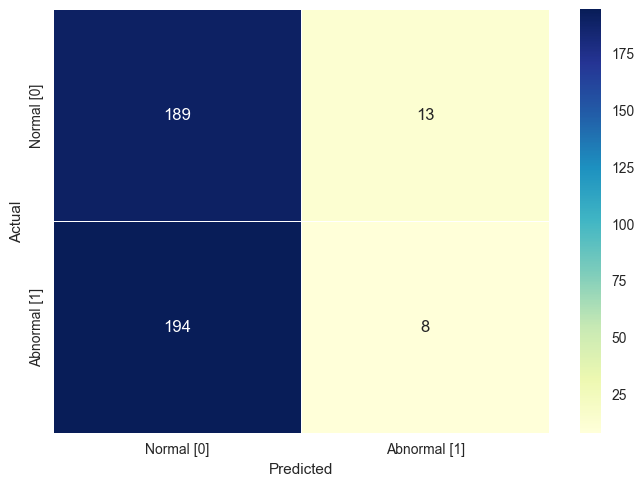

In [459]:
confusionMatrix(predictions[3]['Anomaly'])

In [ ]:
# 3) Normalizing with Numerical Variables -> 현재는 그냥 내버려 두기로
numerical_cols = ["lead_desc_length", "historical_existing_cnt"]
processed_data[numerical_cols].describe()

''' 관련 코드 
# 4. Regularization 
rs = RobustScaler()
ss = StandardScaler()

processed_data.iloc[:, 4:] = rs.fit_transform(processed_data.iloc[:, 4:])
processed_data
'''

In [ ]:
# # 5. Word Embedding for NLP dataset
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# # 1) Tokenizing
# tk_inquiry = Tokenizer()
# tk_business = Tokenizer()
# tk_customer = Tokenizer()
# tk_product = Tokenizer()
# tokenizers = [tk_inquiry, tk_business, tk_customer, tk_product]

# for col, tk in zip(nlp_cols, tokenizers):
#     tk.fit_on_texts(processed_nlp[col])
# #     print(list(tk.word_index.items())[:10])  # 단어집 
#     print(col)
#     print(list(tk.word_counts.items())[:20]) # 단어 빈도 수 
#     print(len(tk.word_index.items()), '\n')        # 단어 개수 

#     # 2) Index Sequencing with Vocabulary Index 
#     seq_data = tk.texts_to_sequences(processed_nlp[col])
#     print(seq_data[0], '\n')

#     # 3) Padding with Sequence 
#     pad_seq_data = pad_sequences(seq_data)
#     print(pad_seq_data.shape, '\n')
    
#     # 4) Concating Sequence Data 
#     pad_seq_data = pd.DataFrame(pad_seq_data)
# #     print(pad_seq_data)
#     processed_nlp = pd.concat([processed_nlp, pad_seq_data], axis=1)